# CIFAR with Data Augmentation

## 載入套件

In [9]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
import torchvision 
from torchvision import transforms
import numpy as np

## 設定參數

In [2]:
# 設定參數
BATCH_SIZE = 1000  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 定義資料增補函數

In [36]:
image_width = 32
train_transforms = transforms.Compose([
    # 裁切部分圖像，再調整圖像尺寸
    #transforms.RandomResizedCrop(image_width, scale=(0.8, 1.0)), 
    #transforms.RandomRotation(degrees=(-10, 10)), # 旋轉 10 度
    #transforms.RandomHorizontalFlip(), # 水平翻轉
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(image_width, padding=4),
    #transforms.ColorJitter(), # 亮度、飽和度、對比資料增補
    #transforms.RandomAffine(10), # 仿射
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])

test_transforms = transforms.Compose([
    transforms.Resize((image_width, image_width)), # 調整圖像尺寸
    transforms.ToTensor(), 
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])

## 步驟1：載入資料集

In [37]:
# 載入資料集，如果出現 BrokenPipeError 錯誤，將 num_workers 改為 0
train_ds = torchvision.datasets.CIFAR10(root='./CIFAR10', train=True,
                                download=True, transform=train_transforms)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE,
                                shuffle=True, num_workers=2)

test_ds = torchvision.datasets.CIFAR10(root='./CIFAR10', train=False,
                                download=True, transform=test_transforms)

test_loader = torch.utils.data.DataLoader(test_ds, batch_size=BATCH_SIZE,
                                shuffle=False , num_workers=2)

# 訓練/測試資料的維度
print(train_ds.data.shape, test_ds.data.shape)

Files already downloaded and verified
Files already downloaded and verified
(50000, 32, 32, 3) (10000, 32, 32, 3)


## 步驟2：資料清理，此步驟無需進行

## 步驟3：特徵工程，此步驟無需進行

## 步驟4：資料分割，此步驟無需進行，載入MNIST資料時，已經切割好了

## 步驟5：建立模型結構

In [38]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 顏色要放在第1維，3:RGB三顏色
        self.conv1 = nn.Conv2d(3, 6, 5) 
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
#         output = F.log_softmax(x, dim=1)
        return x

## 步驟6：結合訓練資料及模型，進行模型訓練

In [39]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    loss_list = []    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        #loss = F.nll_loss(output, target)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx+1) % 10 == 0:
            loss_list.append(loss.item())
            batch = (batch_idx+1) * len(data)
            data_count = len(train_loader.dataset)
            percentage = (100. * (batch_idx+1) / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f} %)' +
                  f'  Loss: {loss.item():.6f}')
    return loss_list

In [40]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            # print(data.shape)
            # print(target)
            if type(data) == tuple:
                data = torch.FloatTensor(data)
            if type(target) == tuple:
                target = torch.Tensor(target)
            data, target = data.to(device), target.to(device)
            output = model(data)
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            _, predicted = torch.max(output.data, 1)
            # print(predicted)
            correct += (predicted == target).sum().item()

    # 平均損失
    test_loss /= len(test_loader.dataset) 
    # 顯示測試結果
    data_count = len(test_loader.dataset)
    percentage = 100. * correct / data_count 
    print(f'準確率: {correct}/{data_count} ({percentage:.2f}%)')

In [52]:
epochs = 20
lr=0.01

# 建立模型
model = Net().to(device)

# 定義損失函數
# 注意，nn.CrossEntropyLoss是類別，要先建立物件，要加 ()，其他損失函數不需要
criterion = nn.CrossEntropyLoss() # F.nll_loss 

# 設定優化器(optimizer)
#optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)

loss_list = []
for epoch in range(1, epochs + 1):
    loss_list += train(model, device, train_loader, criterion, optimizer, epoch)
    #test(model, device, test_loader)
    optimizer.step()

Epoch 1: [10000 / 50000] (20 %)  Loss: 2.300905
Epoch 1: [20000 / 50000] (40 %)  Loss: 2.302145
Epoch 1: [30000 / 50000] (60 %)  Loss: 2.295762
Epoch 1: [40000 / 50000] (80 %)  Loss: 2.296967
Epoch 1: [50000 / 50000] (100 %)  Loss: 2.280695
Epoch 2: [10000 / 50000] (20 %)  Loss: 2.279377
Epoch 2: [20000 / 50000] (40 %)  Loss: 2.274392
Epoch 2: [30000 / 50000] (60 %)  Loss: 2.248450
Epoch 2: [40000 / 50000] (80 %)  Loss: 2.202183
Epoch 2: [50000 / 50000] (100 %)  Loss: 2.185362
Epoch 3: [10000 / 50000] (20 %)  Loss: 2.127601
Epoch 3: [20000 / 50000] (40 %)  Loss: 2.066868
Epoch 3: [30000 / 50000] (60 %)  Loss: 1.988520
Epoch 3: [40000 / 50000] (80 %)  Loss: 2.027357
Epoch 3: [50000 / 50000] (100 %)  Loss: 1.972401
Epoch 4: [10000 / 50000] (20 %)  Loss: 1.930738
Epoch 4: [20000 / 50000] (40 %)  Loss: 1.944878
Epoch 4: [30000 / 50000] (60 %)  Loss: 1.929402
Epoch 4: [40000 / 50000] (80 %)  Loss: 1.947743
Epoch 4: [50000 / 50000] (100 %)  Loss: 1.911450
Epoch 5: [10000 / 50000] (20 %)  Los

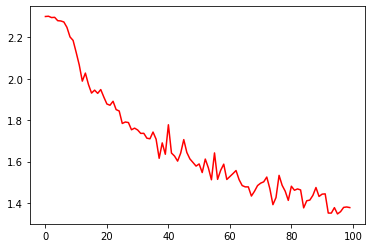

In [53]:
# 對訓練過程的損失繪圖
import matplotlib.pyplot as plt

plt.plot(loss_list, 'r')

## 步驟7：評分(Score Model)

In [54]:
test(model, device, test_loader)

準確率: 4934/10000 (49.34%)


In [11]:
# 實際預測 20 筆資料
predictions = []
with torch.no_grad():
    for i in range(20):
        data, target = test_ds[i][0], test_ds[i][1]
        data = data.reshape(1, *data.shape).to(device)
        output = torch.argmax(model(data), axis=-1)
        predictions.append(str(output.item()))

# 比對
print('actual    :', test_ds.targets[0:20].numpy())
print('prediction: ', ' '.join(predictions[0:20]))

actual    : [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
prediction:  7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4


## 步驟8：評估，暫不進行

## 步驟9：模型佈署

## 步驟10：新資料預測

### 方法1：使用 Pillow 套件

In [15]:
# 顯示圖像
import matplotlib.pyplot as plt

def imshow(X):
    # 繪製點陣圖，cmap='gray':灰階
    plt.imshow(X.reshape(28,28), cmap='gray')

    # 隱藏刻度
    plt.axis('off') 

    # 顯示圖形
    plt.show() 

In [16]:
# 使用PIL讀取檔案，像素介於[0, 255]
import PIL.Image as Image

data_shape = data.shape

for i in range(10):
    uploaded_file = f'./myDigits/{i}.png'
    image1 = Image.open(uploaded_file).convert('L')

    # 縮為 (28, 28) 大小的影像
    image_resized = image1.resize(tuple(data_shape)[2:])
    X1 = np.array(image_resized).reshape([1]+list(data_shape)[1:])
    # 反轉顏色，顏色0為白色，與 RGB 色碼不同，它的 0 為黑色
    X1 = 1.0-(X1/255)

    # 圖像轉換
    X1 = (X1 - 0.1307) / 0.3081  
    
    # 顯示轉換後的圖像
    # imshow(X1)
    
    X1 = torch.FloatTensor(X1).to(device)
    
    # 預測
    output = model(X1)
    # print(output, '\n')
    _, predicted = torch.max(output.data, 1)
    print(f'actual/prediction: {i} {predicted.item()}')

actual/prediction: 0 0
actual/prediction: 1 1
actual/prediction: 2 2
actual/prediction: 3 3
actual/prediction: 4 4
actual/prediction: 5 5
actual/prediction: 6 6
actual/prediction: 7 7
actual/prediction: 8 8
actual/prediction: 9 9


### 方法2：使用 skimage 套件

In [19]:
# 使用 skimage 讀取檔案，像素介於[0, 1]
from skimage import io
from skimage.transform import resize

# 讀取影像並轉為單色
for i in range(10):
    uploaded_file = f'./myDigits/{i}.png'
    image1 = io.imread(uploaded_file, as_gray=True)

    # 縮為 (28, 28) 大小的影像
    image_resized = resize(image1, tuple(data_shape)[2:], anti_aliasing=True)    
    X1 = image_resized.reshape([1]+list(data_shape)[1:]) 
    # 反轉顏色，顏色0為白色，與 RGB 色碼不同，它的 0 為黑色
    X1 = 1.0-X1
    
    # 圖像轉換
    X1 = (X1 - 0.1307) / 0.3081  

    # 顯示轉換後的圖像
    # imshow(X1)
    
    X1 = torch.FloatTensor(X1).to(device)
    
    # 預測
    output = model(X1)
    _, predicted = torch.max(output.data, 1)
    print(f'actual/prediction: {i} {predicted.item()}')

actual/prediction: 0 0
actual/prediction: 1 1
actual/prediction: 2 2
actual/prediction: 3 3
actual/prediction: 4 4
actual/prediction: 5 5
actual/prediction: 6 6
actual/prediction: 7 7
actual/prediction: 8 8
actual/prediction: 9 9


### 方法3：使用自訂資料集

In [20]:
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None, target_transform=None
                 , to_gray=False, size=28):
        self.img_labels = [file_name for file_name in os.listdir(img_dir)]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.to_gray = to_gray
        self.size = size

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # 組合檔案完整路徑
        img_path = os.path.join(self.img_dir, self.img_labels[idx])
        # 讀取圖檔
        mode = 'L' if self.to_gray else 'RGB'
        image = Image.open(img_path, mode='r').convert(mode)
        image = Image.fromarray(1.0-(np.array(image)/255))

        # print(image.shape)
        # 去除副檔名
        label = int(self.img_labels[idx].split('.')[0])
        
        # 轉換
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label

### 預測

In [21]:
ds = CustomImageDataset('./myDigits', to_gray=True, transform=test_transforms)
data_loader = torch.utils.data.DataLoader(ds, batch_size=10,shuffle=False)

test(model, device, data_loader)

準確率: 10/10 (100.00%)


### 驗證

In [23]:
model.eval()
test_loss = 0
correct = 0
with torch.no_grad():
    for data, target in data_loader:
        print(target)
        data, target = data.to(device), target.to(device)
        
        # 預測
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        correct += (predicted == target).sum().item()
        print(predicted)

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], device='cuda:0')
